
# Trabajo práctico integrador

Nombre: _Diego Gutierrez_

## Segunda parte (Aprendizaje Supervisado)

Para la creación de los datasets y la manipulación de los mismos vamos a trabajar directamente con dos módulos includios en la carpeta utils.

En esta podemos encontrar:
 - generate_data: Esta función wrappea el método de _make_regression_ de scikit learn para devolver un dataframe con un problema de regresión basado en sus parámetros.
 - generate_outliers: Esta función genera outliers livianos y pesados en función de los parámetros que le demos de entrada.

In [383]:
%%capture
from utils.data_generation import generate_dataset
from utils.data_manipulation import generate_outliers

import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import plotly.express as px

### Cuarto ejercicio

Utilizando la funcion `generate_data` generar un problema de regresión multivariada en el cual cuente con N variables informativas y M variables no informativas.

Ejemplo:
```python
data = generate_dataset(n_samples=1000,
                    n_features=10,
                    n_informative=5,
                    n_targets=1,
                    noise=20.0,
                    random_state=42,
                    output='dataframe')

```

Analice como varía el problema cuando se generan múltiples veces el dataset con un valor de _noise_ fijo. 

- Qué pasa con los coeficientes de las variables no informativas?
- La regresión se ve afectada por estas variables?
- Simule el mismo dataset 100 veces y analice los coeficientes, que se puede notar?

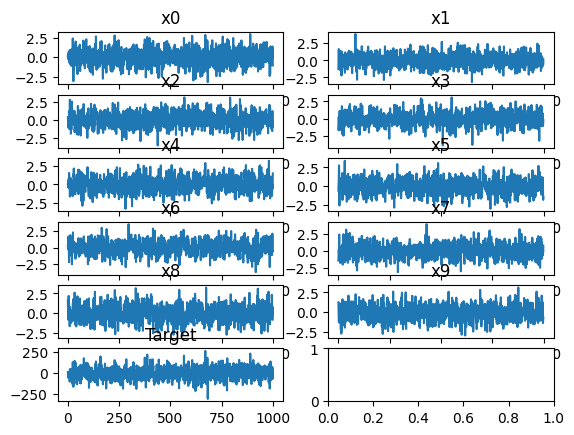

In [384]:
# analisis principal
n_features = 10
rnd_state = 42

data = generate_dataset(n_samples=1000,
                    n_features=n_features,
                    n_informative=5,
                    n_targets=1,
                    noise=20.0,
                    random_state=rnd_state,
                    output='dataframe')

vars = data[[f'x{i}' for i in range(n_features)]]
target = data['target']

fig, ax = plt.subplots(6, 2)
plotx = 0
ploty = 0
for var in vars:
    ax[plotx, ploty].plot(vars[var])
    ax[plotx, ploty].set_title(var)
    ploty += 1
    if ploty >= 2:
        plotx += 1
        ploty = 0

ax[5, 0].plot(target)
ax[5, 0].set_title('Target')

plt.show()

In [385]:
# regresion lineal
segmented = train_test_split(vars, target, train_size=0.7, random_state=rnd_state)
train_vars, test_vars, train_target, test_target = segmented

regr = linear_model.LinearRegression()
regr.fit(train_vars, train_target)

print(f'Score: {regr.score(test_vars, test_target)}')
print(f'Coeficientes: {regr.coef_}')

Score: 0.9262355021544468
Coeficientes: [59.01997238 -0.90875382  0.13748807 32.09087696  6.41537973  0.63550219
  9.98459302 -0.56059279 -1.23026412 10.26521007]


A partir de los coeficientes observados en la regresión, inferimos que las variables informativas son 0, 3, 4, 6, 9 (aquellas con coeficientes distantes del 0, que se hace evidente considerando la distancia entre las variables origen y la destino en este dataset). Creamos un subset que las excluye, para realizar otra regresión y comparar los resultados.

In [386]:
clean_vars = data[[f'x{i}' for i in [0, 3, 4, 6, 9]]]
segmented = train_test_split(clean_vars, target, train_size=0.7, random_state=rnd_state)
train_vars, test_vars, train_target, test_target = segmented

regr = linear_model.LinearRegression()
regr.fit(train_vars, train_target)

print(f'Score: {regr.score(test_vars, test_target)}')
print(f'Coeficientes: {regr.coef_}')

Score: 0.926865584383821
Coeficientes: [59.03096175 32.17987567  6.31167327 10.00151758 10.29308119]


Comparando el score de predicción y los coeficientes, vemos que haber quitado las variables no informativas tiene un mínimo impacto sobre el modelo.

#### Repetición de regresión con diferentes random seed

Para poder observar el comportamiento de los coeficientes

In [387]:
# semillas random - pedimos inicialmente 200 como margen de seguridad para
# tener finalmente al menos 100 valores diferentes
seeds = np.random.randint(low=0, high=1000, size=200)
seeds = sorted(np.unique(seeds)[:100])

# coeficientes de cada prueba
coefs = {}

# loop
for seed in seeds:
    data = generate_dataset(n_samples=1000,
                        n_features=n_features,
                        n_informative=5,
                        n_targets=1,
                        noise=20.0,
                        random_state=seed,
                        output='dataframe')

    vars = data[[f'x{i}' for i in range(n_features)]]
    target = data['target']

    # modelo
    regr = linear_model.LinearRegression()
    regr.fit(vars, target)

    coefs[seed] = regr.coef_

# coeficientes convertidos en dataframe por comodidad
coefs = pd.DataFrame(coefs).T

In [388]:
pd.options.plotting.backend = 'plotly'

plot_coefs = coefs.iloc[:, ]
plot_coefs.plot.line()

Mirando el comportamiento de los coeficientes al variar la semilla random con la que se genera el dataset, no hay patrones observables: las líneas parecen tan random como los valores que les dieron origen.

Corriendo la regeneración y regresión lineal con diferente random seed en forma interactiva, se observa que las variables informativas no son siempre las mismas, lo que explica este comportamiento errático.

### Quinto ejercicio

Utilizando la funcion `generate_outliers` generar puntos extremos dentro de los datos que generamos anteriormente. En este ejercicio dejar setteado `extreme_outliers` como `False` y observe como variando el porcentaje de los mismos la regresión comienza a afectarse.

Pasos:

1. Generar datasets:
    - Uno normal con poco `noise` y pocos outliers
    - Uno con mucho `noise` y pocos outliers
    - Uno con poco `noise` y muchos outliers
    - Uno con mucho `noise` y muchos outliers
2. Probar los distintos regresores a ver como se comportan frente a estos datasets anómalos.
3. Comparar y analizar resultados.

In [396]:
# parameters
rnd_state = 42
noise_rates = {'20': 20.0, '40': 40.0, '60': 60.0, '80': 80.0}
outliers_rates = {'02': 0.02, '1': 0.1, '2': 0.2, '4': .4, '6': .6}
regressors = [linear_model.LinearRegression, linear_model.HuberRegressor, linear_model.ElasticNetCV]

col_n = 10
cols = [f'x{i}' for i in range(col_n)]

# results dataframe
tests = {}
for noise_k, noise_v in noise_rates.items():
    for outlier_k, outlier_v in outliers_rates.items():
        key = f'noise{noise_k}-outlier{outlier_k}'
        tests[key] = {}
        dataset = generate_outliers(
                generate_dataset(n_features=col_n, noise=noise_v),
              percentage=outlier_v, cols=cols)
#        tests[key]['data'] = dataset
        
        vars = dataset[cols]
        target = dataset['target']
        segmented = train_test_split(vars, target, train_size=0.7, random_state=rnd_state)
        train_vars, test_vars, train_target, test_target = segmented

        for regr_c in regressors:
            regr = regr_c()
            regr.fit(train_vars, train_target)

            tests[key][regr_c.__name__] = regr.score(test_vars, test_target)

pd.DataFrame(tests).T

,LinearRegression,HuberRegressor,ElasticNetCV
noise20-outlier02,0.924028,0.924124,0.919385
noise20-outlier1,0.922637,0.922929,0.918137
noise20-outlier2,0.922608,0.922703,0.918406
noise20-outlier4,0.923841,0.923861,0.919364
noise20-outlier6,0.922251,0.922388,0.918909
noise40-outlier02,0.757472,0.758043,0.754432
noise40-outlier1,0.757428,0.758088,0.753653
noise40-outlier2,0.759563,0.759920,0.755928
noise40-outlier4,0.759181,0.759724,0.755328
noise40-outlier6,0.759948,0.760453,0.756290


De forma poco intuitiva, los outliers no parecen tener mayor efecto sobre los regresores (incluso mejorando el score respecto del dataset sin outliers en ocasiones). El ruido en cambio se comporta de forma predecible: a mayor ruido, peor la predicción.